In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
! pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn xgboost scipy optuna

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, 
    classification_report, fbeta_score, roc_auc_score, 
    f1_score, make_scorer, precision_score, recall_score, 
    PrecisionRecallDisplay, precision_recall_curve, 
    average_precision_score, confusion_matrix
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBRegressor, XGBClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_classification
from scipy.spatial import distance_matrix
from collections import Counter
from sklearn.base import clone
import optuna
from optuna.samplers import TPESampler, RandomSampler

# Suppress future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
_ = pd.option_context("mode.use_inf_as_na", True)

# Set plot style and figure size
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 15})


df = pd.read_parquet('cleaned_hospital_readmission.parquet')


y = df.readmitted.copy()
col_to_use = [
    'race', 'gender', 'age', 'time_in_hospital', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient',
    'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
    'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
    'glyburide-metformin', 'change', 'diabetesMed', 'admission_type',
    'admission_sources', 'discharge_dispositions', 'primary_diagnosis_1',
    'primary_diagnosis_2', 'primary_diagnosis_3'
]
X = df[col_to_use].copy()

numerical_cols = []
categorical_cols =[]
for x in X.columns:
    if df[x].dtype in ['object', 'category']:
        categorical_cols.append(x)
    elif df[x].dtype == 'int64':
        numerical_cols.append(x)


# now we label those that were readmitted within 30 days as 1 and all other as zero
y = y.apply(lambda x: 1 if x == '<30' else 0)

y.value_counts(normalize=True), y.shape

(readmitted
 0    0.884783
 1    0.115217
 Name: proportion, dtype: float64,
 (95672,))

In [3]:
from sklearn.metrics import classification_report, fbeta_score, roc_auc_score, f1_score

def evaluate_model(model, X_test, y_test, threshold=0.5):

    # Predict probabilities if model supports it
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]  # Get probability for class 1
        y_pred = (y_probs > threshold).astype(int)  # Apply threshold
    else:
        y_pred = model.predict(X_test)  # Use direct predictions if no predict_proba

    # Compute classification metrics
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))

    f1 = f1_score(y_test, y_pred, pos_label=1)
    f2 = fbeta_score(y_test, y_pred, beta=2, pos_label=1)

    # Compute ROC-AUC score if probabilities are available
    roc_auc = roc_auc_score(y_test, y_probs) if hasattr(model, "predict_proba") else "N/A"

    print(f"F1 Score for Class 1: {f1:.4f}")
    print(f"F2 Score for Class 1: {f2:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}" if roc_auc != "N/A" else "ROC-AUC Score: N/A (No probability estimates)")

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, random_state=1984, stratify=y, train_size=0.6
)

# hold out set for calibration, and testing
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, random_state=1984, stratify=y_temp, train_size=0.5
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

total_negative_samples, total_positive_samples = y_train.value_counts()
scale_pos_weight = total_negative_samples / total_positive_samples

xgb_class_weight_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost', XGBClassifier(random_state=1984, scale_pos_weight=scale_pos_weight))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost', XGBClassifier(random_state=1984))
])

# plan to undersample and test the model later on

xgb_pipeline.fit(X_train, y_train)
xgb_class_weight_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'metformin', 'repaglinide',
                                                   'nateglinide',
                                                   'chlorpropamide',
                                                   'glimepiride', 'glipizide',
                                                   'glyburide', 'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'insulin',
                                                   'glyburide-metformin',
                                                   'change', 'diabetesMed',
                                                   'admission_typ...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=1984, ...))])

In [6]:
evaluate_model(xgb_pipeline, X_train, y_train)

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.89      1.00      0.94     50789
     Class 1       0.95      0.09      0.17      6614

    accuracy                           0.89     57403
   macro avg       0.92      0.55      0.56     57403
weighted avg       0.90      0.89      0.85     57403

F1 Score for Class 1: 0.1679
F2 Score for Class 1: 0.1124
ROC-AUC Score: 0.8194


In [7]:
evaluate_model(xgb_class_weight_pipeline, X_train, y_train)

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.96      0.74      0.83     50789
     Class 1       0.27      0.74      0.40      6614

    accuracy                           0.74     57403
   macro avg       0.61      0.74      0.62     57403
weighted avg       0.88      0.74      0.78     57403

F1 Score for Class 1: 0.3978
F2 Score for Class 1: 0.5517
ROC-AUC Score: 0.8293


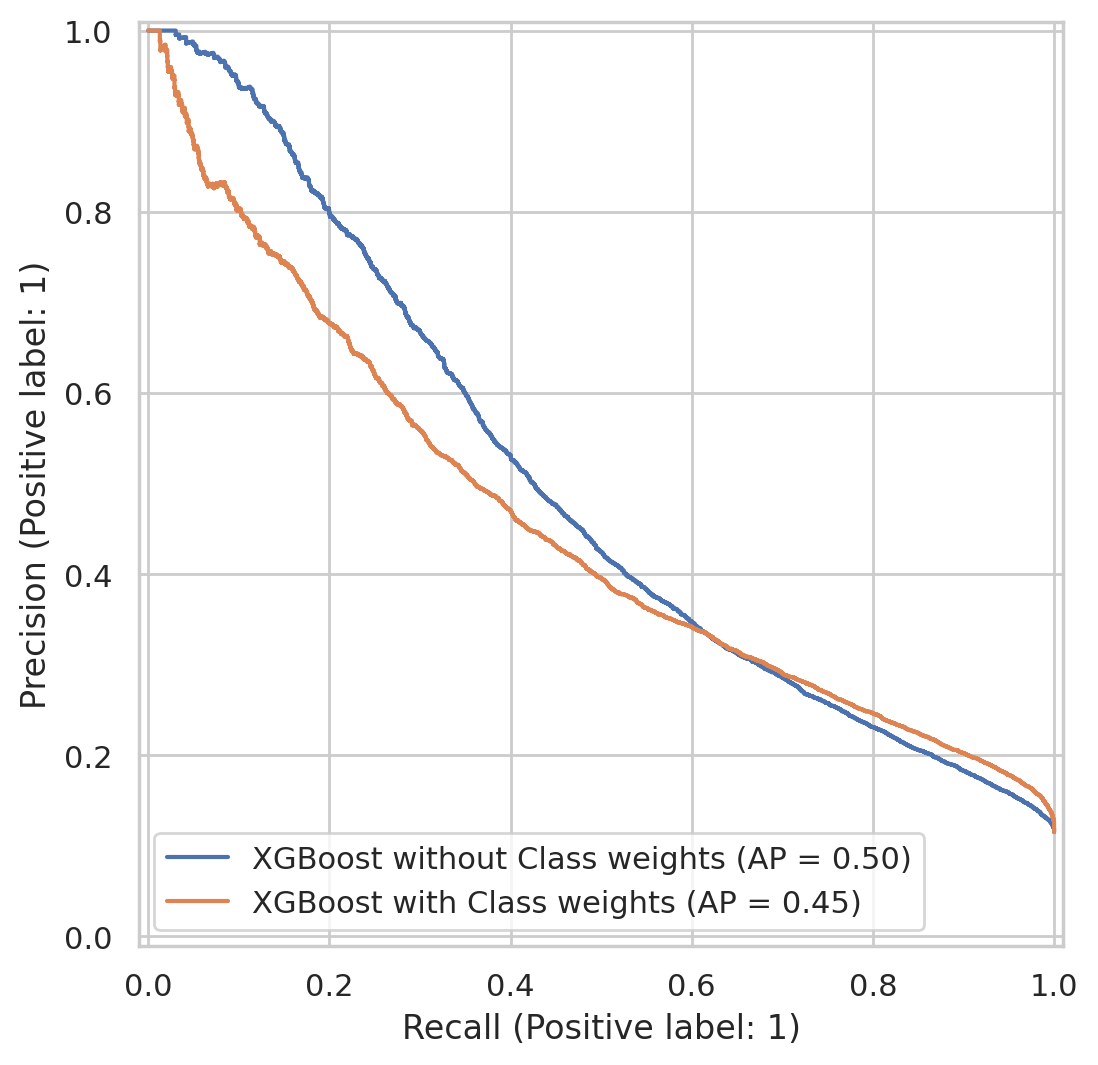

In [8]:
(
    PrecisionRecallDisplay
    .from_estimator(
        xgb_pipeline,
        X_train, y_train,
        ax = plt.gca(),
        name = "XGBoost without Class weights")
)

(
    PrecisionRecallDisplay
    .from_estimator(
        xgb_class_weight_pipeline,
        X_train, y_train,
        ax = plt.gca(),
        name = "XGBoost with Class weights")
);

# there curves do not help that much, check the f2 scores and the recall to see the difference
# the average precision (AP) has dropped because recall improved. This is expected since there is a trade off between 
# precision and recall

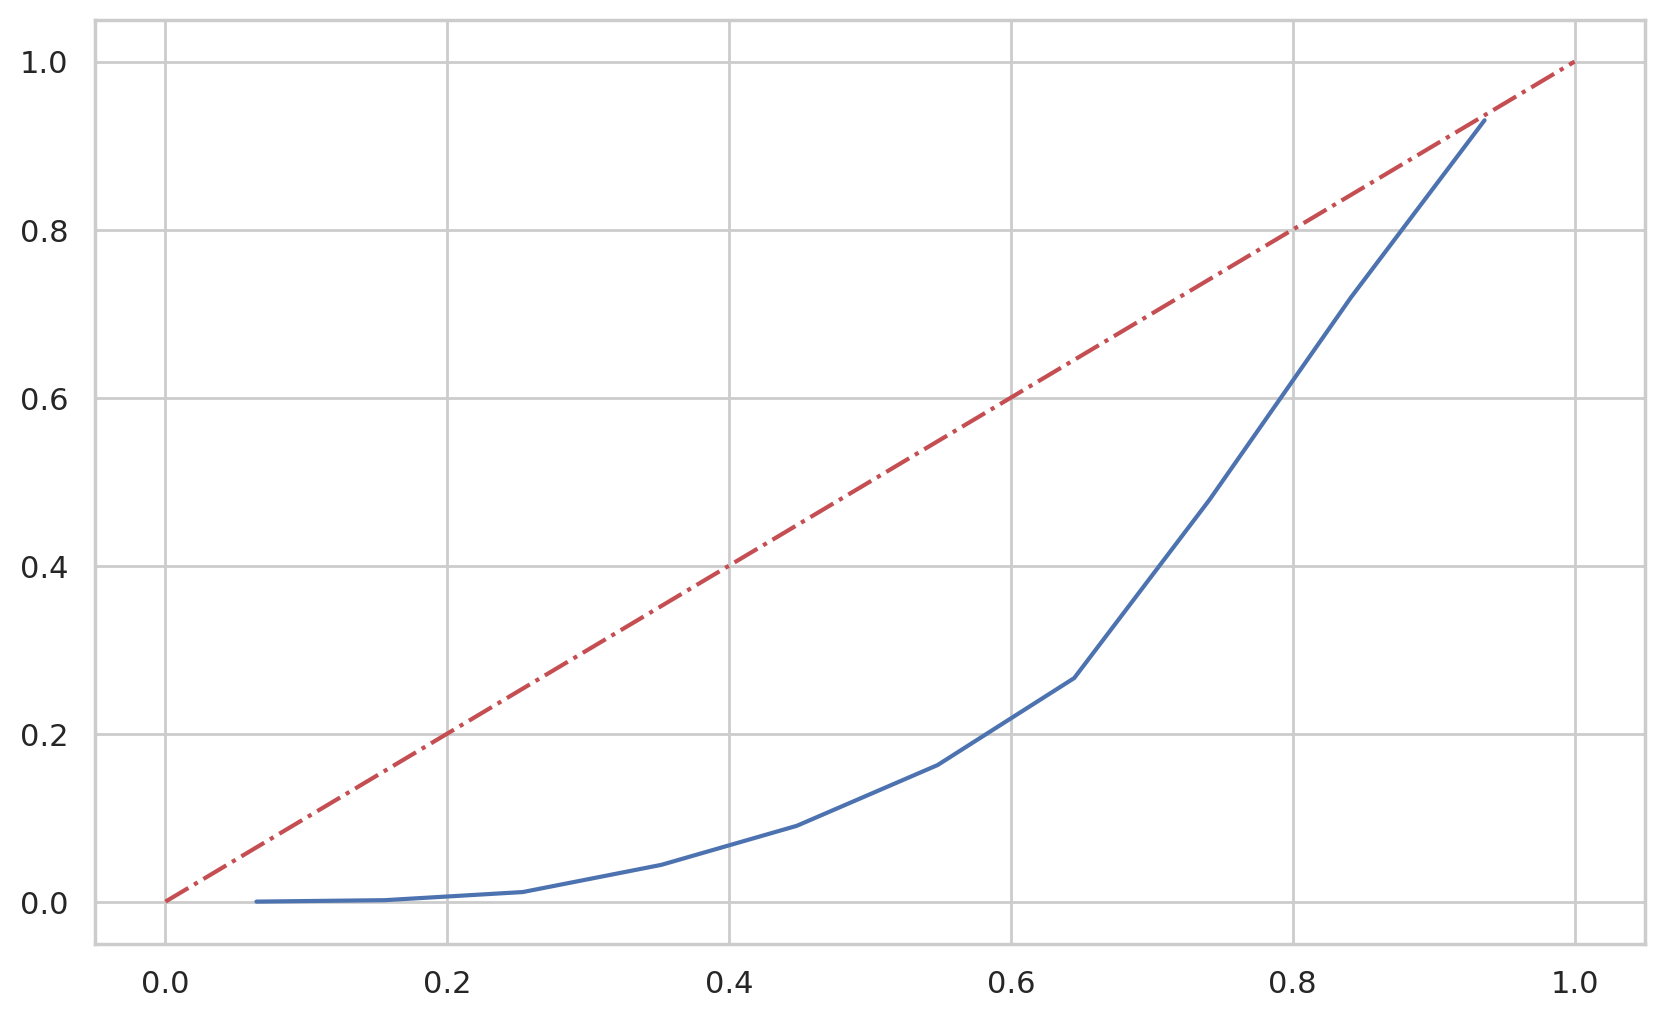

In [9]:
# plot the calibration curves before calibrating

from sklearn.calibration import calibration_curve
bins = 10
y_probs = xgb_class_weight_pipeline.predict_proba(X_train)[:, 1]
fraction_of_positives, mean_pred_bin = calibration_curve(y_train, y_probs, n_bins=bins)
plt.plot(mean_pred_bin, fraction_of_positives)
line = np.linspace(0, 1, bins)
_ = plt.plot(line, line, 'r-.')
# the smiling face means that our model is overpredicting the true proportion of the positive class. For 0.6 probability of positive class; the 
# proportion is actually 0.2

In [10]:
from sklearn.frozen import FrozenEstimator
from sklearn.metrics import brier_score_loss

calibrated_model = CalibratedClassifierCV(FrozenEstimator(xgb_class_weight_pipeline), method='isotonic', cv=10)
calibrated_model.fit(X_calib, y_calib)

y_calibrated_probs = calibrated_model.predict_proba(X_calib)
brier_score_loss(y_calib, y_calibrated_probs[:, 1]) # this score is misleading in case of class imbalance; low is supposed to be good

np.float64(0.0992641405667798)

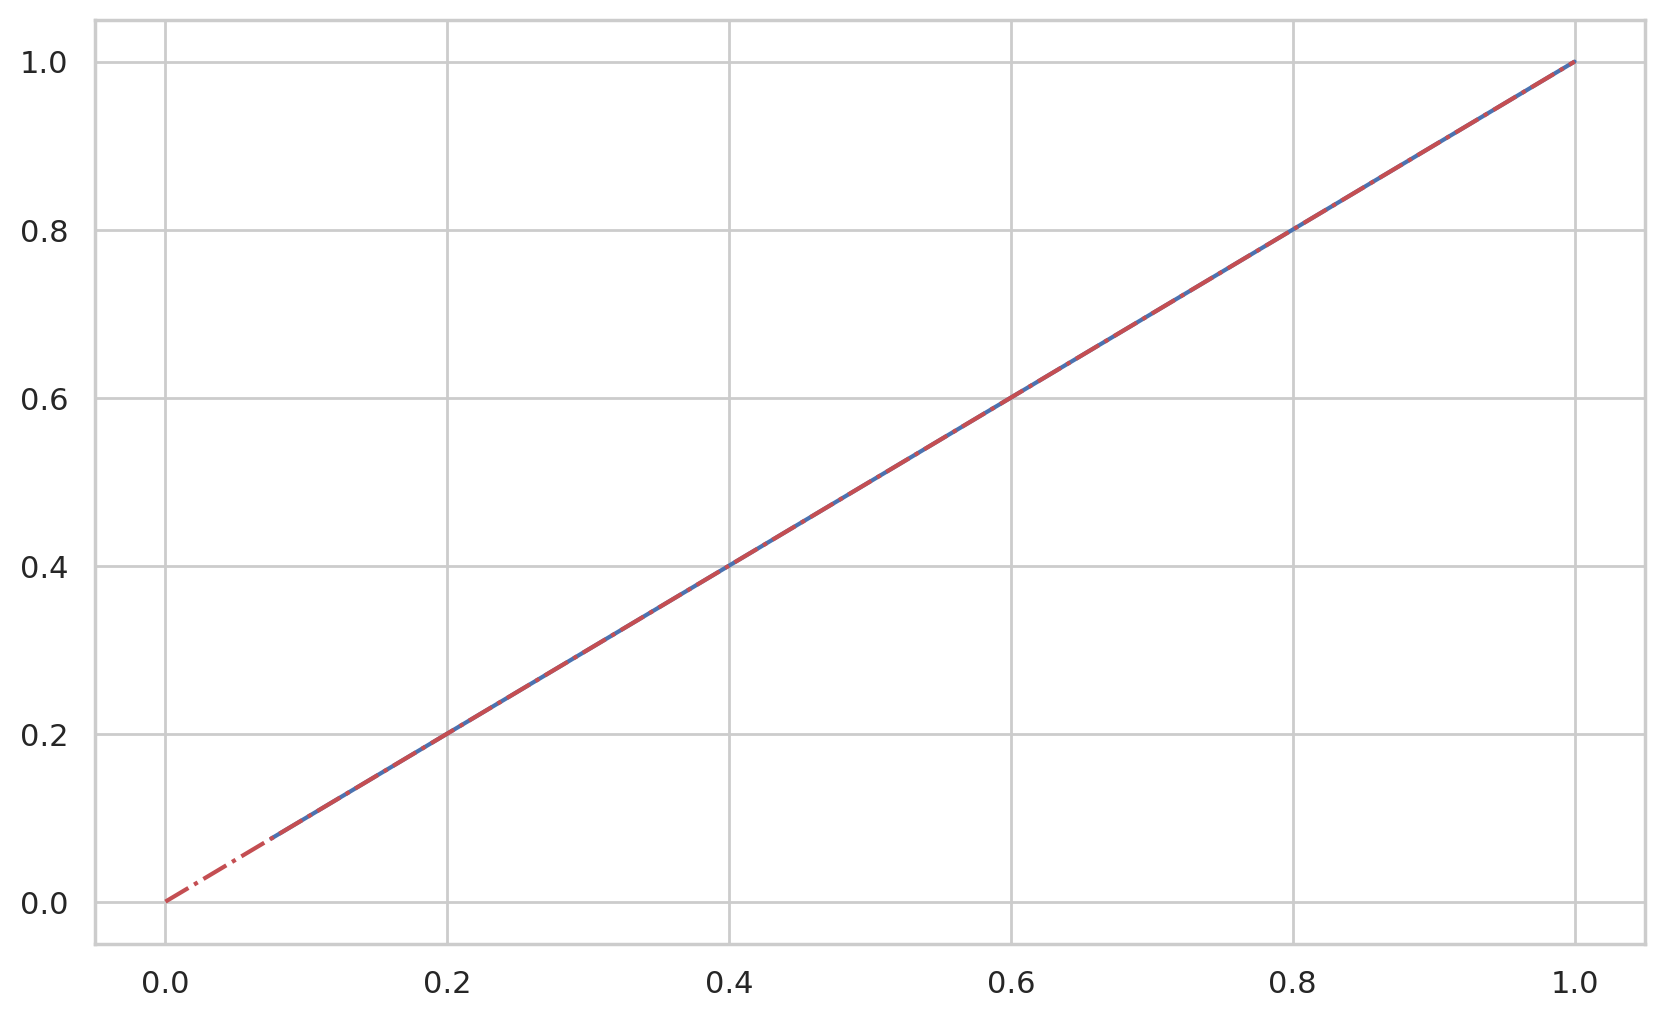

In [11]:
fraction_of_positives, mean_pred_bin = calibration_curve(y_calib, y_calibrated_probs[:, 1], n_bins=bins)
plt.plot(mean_pred_bin, fraction_of_positives)
line = np.linspace(0, 1, bins)
_ = plt.plot(line, line, 'r-.') # this is a calibrated model, where the prob return the actual proportion of positives in each class

In [12]:
# threshold tuning to find the optimal f2 score
def find_best_threshold(model, X, y):
    max_f2 = -float('inf')
    max_f2_threshold = -float('inf')
    # do cross validation and check for the best f2 score for a 
    for threshold in np.linspace(0, 1, 100):
        y_probs = model.predict_proba(X)[:, 1]  # Get probability for class 1
        y_pred = (y_probs > threshold).astype(int)  # Apply threshold
        f2 = fbeta_score(y, y_pred, beta=2, pos_label=1)
        if f2 > max_f2:
            max_f2_threshold = threshold
            max_f2 = f2
    return max_f2_threshold, max_f2

In [14]:
max_f2_threshold, max_f2 = find_best_threshold(calibrated_model, X_train, y_train)
max_f2_threshold, max_f2

(np.float64(0.12512512512512514), 0.5441823808699998)

In [15]:
evaluate_model(calibrated_model, X_train, y_train, threshold=max_f2_threshold)

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.97      0.61      0.75     50789
     Class 1       0.22      0.86      0.35      6614

    accuracy                           0.64     57403
   macro avg       0.60      0.73      0.55     57403
weighted avg       0.88      0.64      0.70     57403

F1 Score for Class 1: 0.3519
F2 Score for Class 1: 0.5442
ROC-AUC Score: 0.8256


In [16]:
evaluate_model(calibrated_model, X_test, y_test, threshold=max_f2_threshold)

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.92      0.58      0.71     16930
     Class 1       0.16      0.61      0.25      2205

    accuracy                           0.59     19135
   macro avg       0.54      0.59      0.48     19135
weighted avg       0.83      0.59      0.66     19135

F1 Score for Class 1: 0.2523
F2 Score for Class 1: 0.3883
ROC-AUC Score: 0.6222


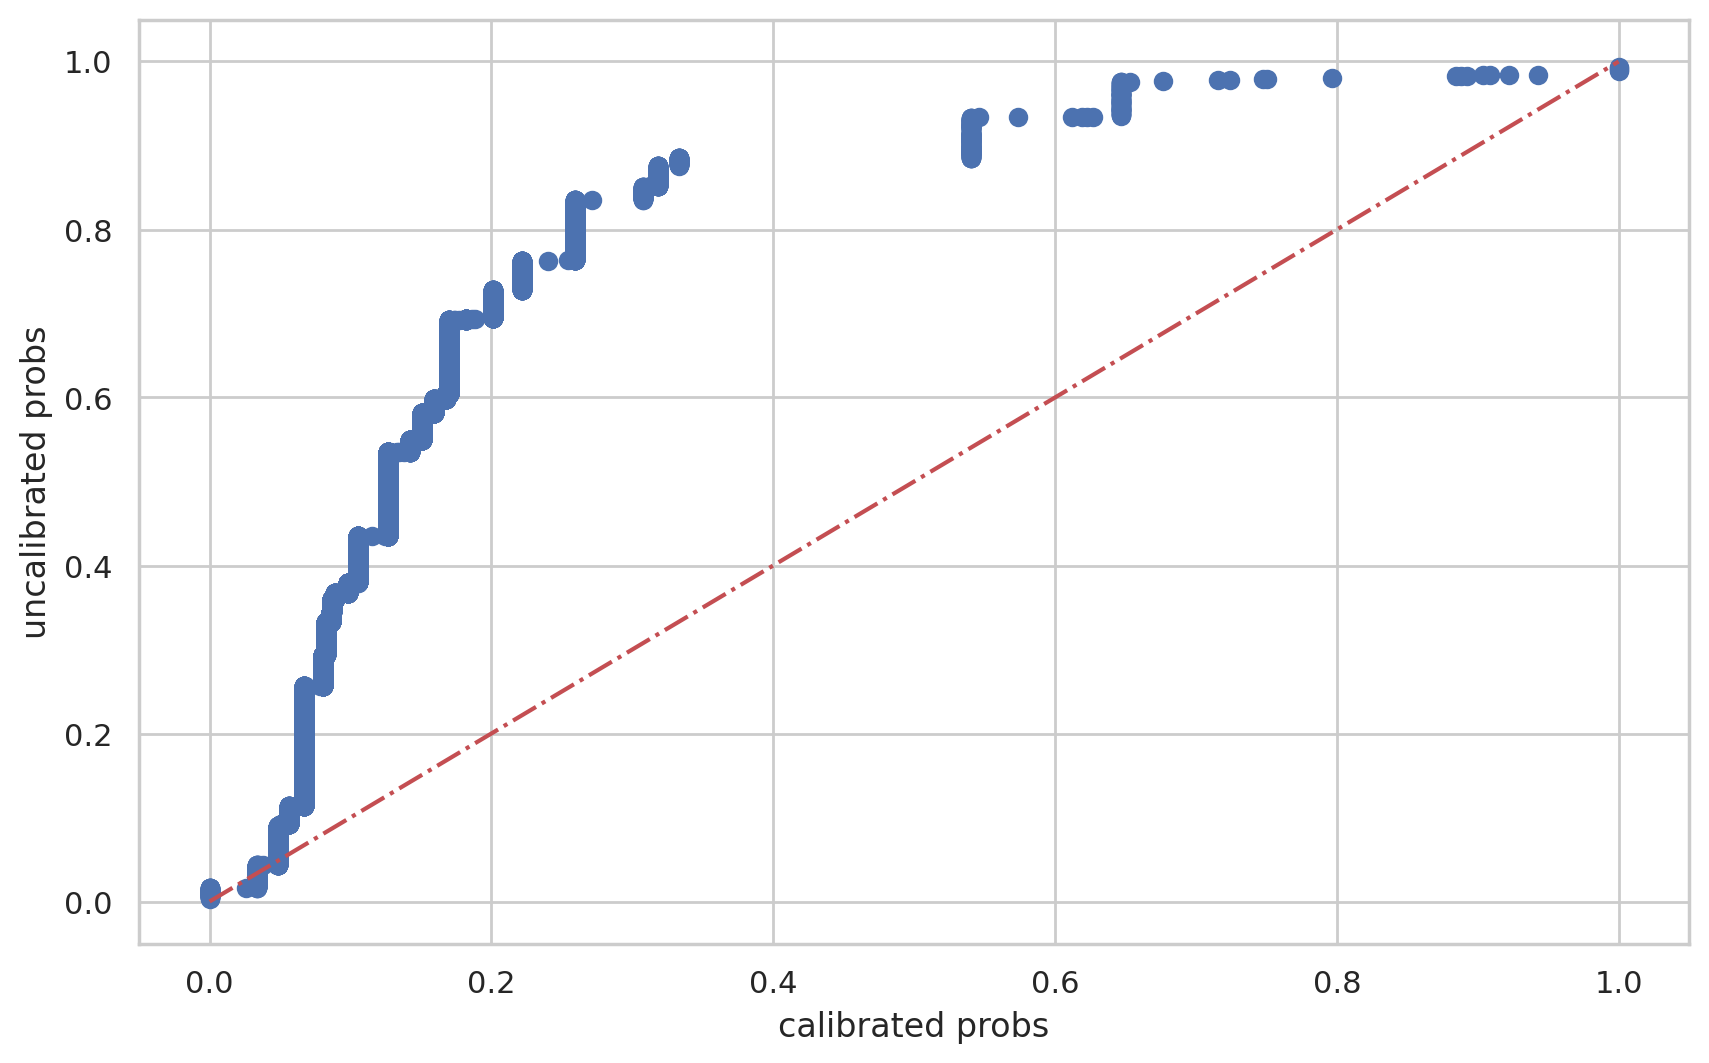

In [17]:
# curve shows how the model overpredicts the true proportions of the positive class
calib_probs = calibrated_model.predict_proba(X_train)[:, 1]
uncalib_probs = xgb_class_weight_pipeline.predict_proba(X_train)[:, 1]
_ = plt.scatter(calib_probs, uncalib_probs)
plt.xlabel('calibrated probs')
plt.ylabel('uncalibrated probs')
plt.plot([0, 1], [0, 1], 'r-.')

In [19]:
# try with bayesian optimization and see if you get similar results or not.



optuna.logging.set_verbosity(optuna.logging.WARNING)
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

# Define the objective function for optimization
def objective(trial):
    params = {
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 5, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    xgb_class_weight_pipeline.set_params(**{'xgboost__' + k: v for k, v in params.items()})

    scores = cross_val_score(xgb_class_weight_pipeline, X_train, y_train, cv=5, scoring=f2_scorer)
    return scores.mean()

# Run Bayesian Optimization
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=100)

# Get best hyperparameters
best_params = study.best_params

# Train final model with best hyperparameters
xgb_best_pipeline = xgb_class_weight_pipeline.set_params(**{'xgboost__' + k: v for k, v in best_params.items()})
xgb_best_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'metformin', 'repaglinide',
                                                   'nateglinide',
                                                   'chlorpropamide',
                                                   'glimepiride', 'glipizide',
                                                   'glyburide', 'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'insulin',
                                                   'glyburide-metformin',
                                                   'change', 'diabetesMed',
                                                   'admission_typ...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07656863414575588, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=166,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=1984, ...))])

In [20]:
best_params # the best parameters are very close to the original ones 

{'scale_pos_weight': 9.903659338364974,
 'n_estimators': 166,
 'learning_rate': 0.07656863414575588,
 'max_depth': 3,
 'subsample': 0.8434226991527956,
 'colsample_bytree': 0.5887056094127622}

In [21]:
evaluate_model(xgb_best_pipeline, X_train, y_train)

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.94      0.50      0.65     50789
     Class 1       0.16      0.75      0.27      6614

    accuracy                           0.53     57403
   macro avg       0.55      0.62      0.46     57403
weighted avg       0.85      0.53      0.61     57403

F1 Score for Class 1: 0.2676
F2 Score for Class 1: 0.4358
ROC-AUC Score: 0.6852


In [22]:
# now the best model need to be calibrated as well before it can be used

best_calibrated_model = CalibratedClassifierCV(FrozenEstimator(xgb_best_pipeline), method='isotonic', cv=10)
best_calibrated_model.fit(X_calib, y_calib)
max_f2_threshold, max_f2 = find_best_threshold(best_calibrated_model, X_train, y_train)
max_f2_threshold, max_f2

(np.float64(0.08408408408408408), 0.4366325252629231)

In [23]:
evaluate_model(best_calibrated_model, X_test, y_test, threshold=max_f2_threshold)

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.93      0.47      0.63     16930
     Class 1       0.16      0.74      0.26      2205

    accuracy                           0.50     19135
   macro avg       0.54      0.61      0.44     19135
weighted avg       0.84      0.50      0.59     19135

F1 Score for Class 1: 0.2573
F2 Score for Class 1: 0.4237
ROC-AUC Score: 0.6569
